# Time Series Modeling

This notebook will contain time series models from statsmodels (ARIMA/SARIMAX) and Facebook Prophet. Previous models used current weather conditions to predict solar energy production three hours in advance. With time series modeling, I plan on forecasting 1-6 hours into the future. 

Previous model's would have performed better with the addition of solar radiation data, as that is the primary predictor of solar energy production. Since solar radiation is highly time dependent, I am hoping a time series model will be able to pick up on solar radiation fluctuation, making for more accurate forecasts.

Notebook Plan:
- Data Prep/Stationarity
- ARIMA (solar energy production only)
- SARIMAX (include weather conditions)
- Facebook Prophet

After further research, there may be some additional feature engineering throughout as well. For example, with wind direction. The current wind direction values use compass directions from true north (360=true north, 180=south, 270=west, etc). However it is likely the model is simply picking up on the magnitude of these values, rather than the direction they represent. For this reason, I want to combine the wind direction and wind speed as a vector. This thought came from looking at Tensorflow time series tutorial, where they use Neural Networks to make weather predictions.

In [113]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Time Series
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as mse

# Imputer object
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Data Scaling
from sklearn.preprocessing import StandardScaler

# Facebook Prophet
from fbprophet import Prophet

# Use of functions from src/
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import data_gathering as dg
from src import data_processing as dp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Prep

I will begin by importing both the energy data and weather data from data_gathering file in src/

In [4]:
# Energy dataframe
energy = dg.energy_data()
# Weather dataframe
weather = dg.weather_data()

Since I am beginning with the ARIMA model, which does not use the weather data, I will hold off on processing that data until it is necessary. First, I will focus on the energy data alone.

In [5]:
energy.head()

,nexus_meter,week,hour
time,,,
2017-01-01 00:00:00,-64.8,52,0
2017-01-01 01:00:00,-64.9,52,1
2017-01-01 02:00:00,-77.7,52,2
2017-01-01 03:00:00,-76.0,52,3
2017-01-01 04:00:00,-72.0,52,4


During previous models, the time of year and day were key predictors for energy production. Since this is a time series analysis, these are no longer necessary.

In [6]:
energy.drop(['week', 'hour'], axis=1, inplace=True)

In [7]:
energy.head()

,nexus_meter
time,
2017-01-01 00:00:00,-64.8
2017-01-01 01:00:00,-64.9
2017-01-01 02:00:00,-77.7
2017-01-01 03:00:00,-76.0
2017-01-01 04:00:00,-72.0


Next I will plot the energy data along the entire time frame.

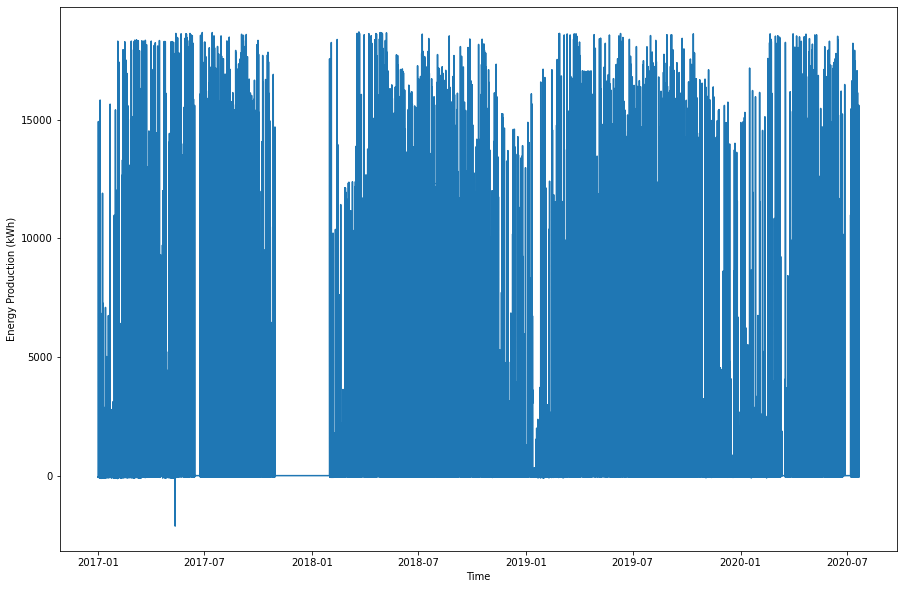

In [9]:
fig = plt.figure(figsize=(15,10))
plt.plot(energy)
plt.xlabel('Time')
plt.ylabel('Energy Production (kWh)')
plt.show()

There is a large gap of data that was not collected between the end of 2017 and beginning of 2018, I will focus my analysis on the data following the gap in 2018 onward.

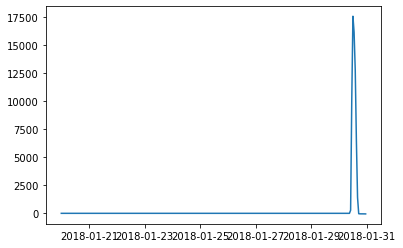

In [22]:
plt.plot(energy['2018-01-20': '2018-01-30'])

The data was collected starting on January 30, 2018 after the gap. So I will slice the dataframe to contain data from that data until the end of the dataframe.

In [23]:
energy = energy['2018-01-30':]

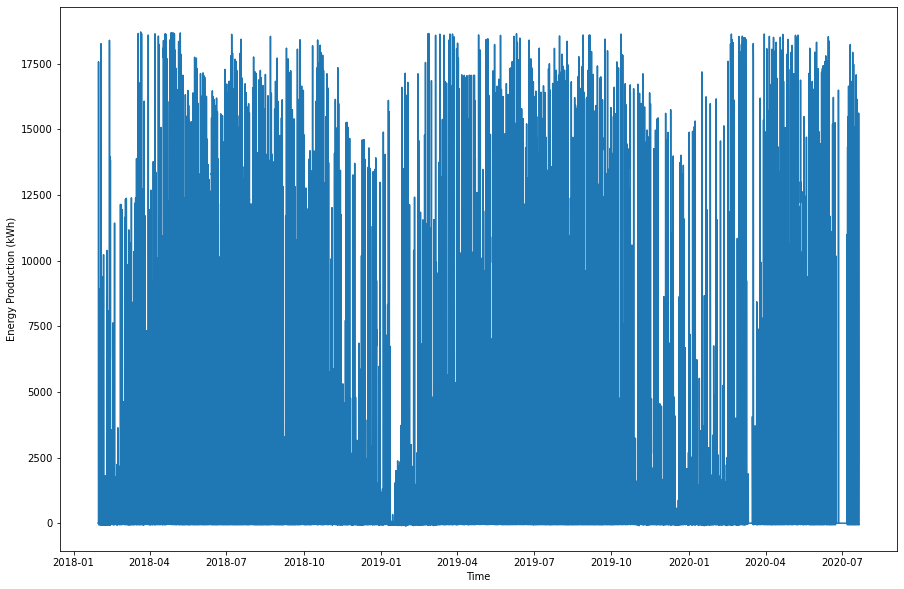

In [24]:
fig = plt.figure(figsize=(15,10))
plt.plot(energy)
plt.xlabel('Time')
plt.ylabel('Energy Production (kWh)')
plt.show()

It's quite difficult to obtain any useful information from the plot above. Instead, i will plot the total daily energy production.

In [25]:
daily_energy = energy.resample('D').sum()

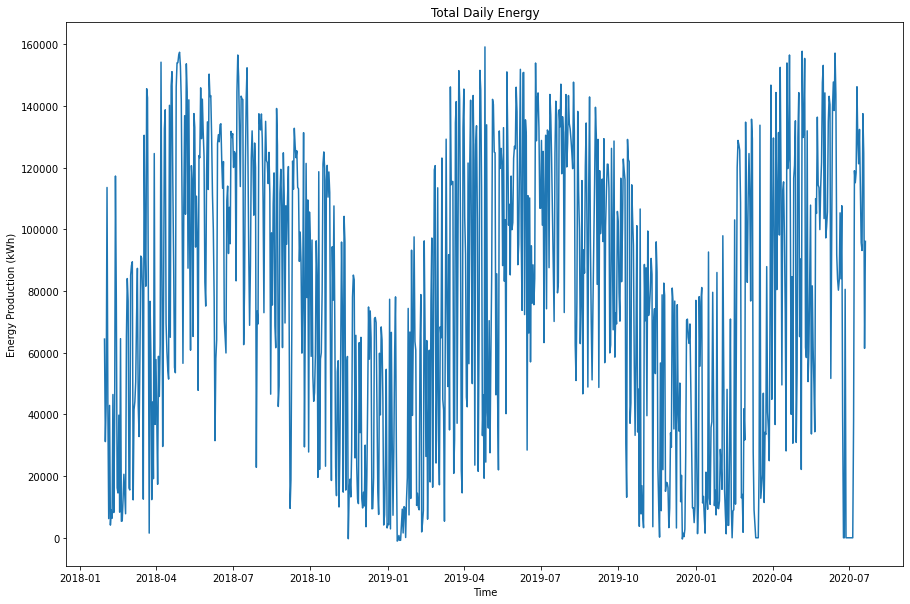

In [27]:
fig = plt.figure(figsize=(15,10))
plt.plot(daily_energy)
plt.xlabel('Time')
plt.ylabel('Energy Production (kWh)')
plt.title('Total Daily Energy')
plt.show()

## Stationarity

A key component of time series analysis is that the data is stationary. To check this, I will use the dickey-fuller test. The dickey-fuller test runs a statistical analysis on the data returning a test statistic and p-value. A p-value of less than .5 indicates the series is stationary.

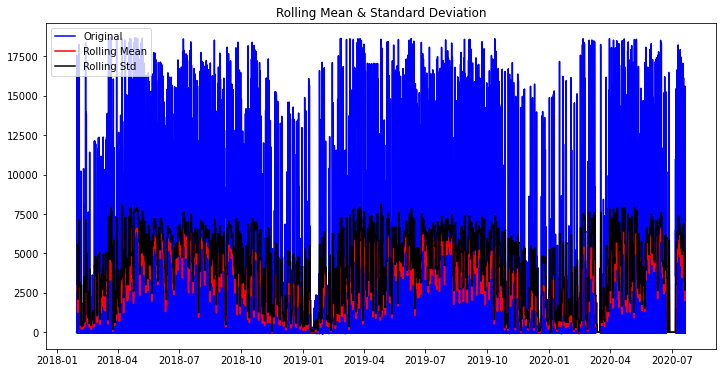

Results of Dickey-Fuller Test: 

Test Statistic                -1.046908e+01
p-value                        1.298466e-18
#Lags Used                     4.700000e+01
Number of Observations Used    2.162400e+04
Critical Value (1%)           -3.430652e+00
Critical Value (5%)           -2.861674e+00
Critical Value (10%)          -2.566841e+00
dtype: float64


In [34]:
dp.stationarity_check(energy)

I would have assumed the time series to be non-stationary, considering how dependent it is on time. Nontheless, i will now move forward with ARIMA modeling. The first step is to split the data into three sections: training, validation, and testing sets.

### Train-Test-Split

In [36]:
energy.shape

(21672, 1)

There are 21,672 total data points, the majority of which (70%) I would like to use for training the model. I will perform a 70-15-15 split. The validation data will be used to guage the accuracy of model iterations until the very end, when I check the test set on the best performing model.

In [41]:
train_size = int(21672 * .7)
val_size = int(21672 * .15)

In [42]:
energy_train = energy.iloc[:train_size]
energy_val = energy.iloc[train_size: train_size+val_size]
energy_test = energy.iloc[train_size+val_size:]

I would like to visualize the split and ensure it is continous. So I will plot the entire energy dataframe, using different colors for each data split.

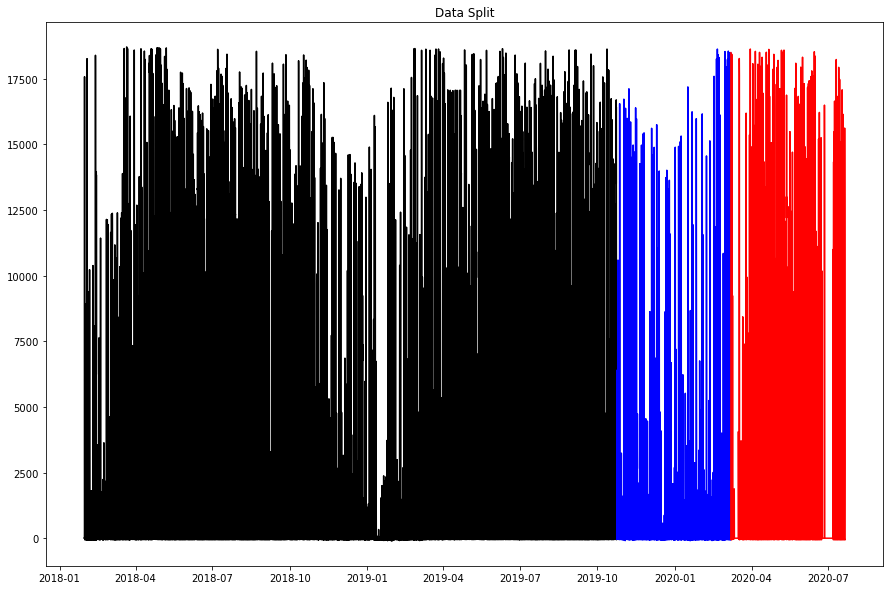

In [43]:
fig = plt.figure(figsize=(15,10))
plt.plot(energy_train, color='black')
plt.plot(energy_val, color='blue')
plt.plot(energy_test, color='red')
plt.title("Data Split")
plt.show()

There seems to be no gaps between the data splits. Just to be sure however, I can check each dataframe itself.

In [45]:
energy_train

,nexus_meter
time,
2018-01-30 00:00:00,0.00
2018-01-30 01:00:00,0.00
2018-01-30 02:00:00,0.00
2018-01-30 03:00:00,0.00
2018-01-30 04:00:00,0.00
...,...
2019-10-23 21:00:00,-49.60
2019-10-23 22:00:00,-45.40
2019-10-23 23:00:00,-41.22


In [46]:
energy_val

,nexus_meter
time,
2019-10-24 02:00:00,-39.49
2019-10-24 03:00:00,-39.64
2019-10-24 04:00:00,-39.78
2019-10-24 05:00:00,-39.78
2019-10-24 06:00:00,-42.80
...,...
2020-03-07 07:00:00,5409.00
2020-03-07 08:00:00,11045.00
2020-03-07 09:00:00,15345.00


In [47]:
energy_test

,nexus_meter
time,
2020-03-07 12:00:00,18488.000
2020-03-07 13:00:00,17703.000
2020-03-07 14:00:00,15020.000
2020-03-07 15:00:00,10801.000
2020-03-07 16:00:00,4568.000
...,...
2020-07-20 19:00:00,625.100
2020-07-20 20:00:00,-0.003
2020-07-20 21:00:00,-54.500


There are no gaps between the data splits, so i can proceed with modeling. 

### Data splits:
- Training -> 2018-01-30 00:00:00 - 2019-10-24 01:00:00
- Validataion -> 2019-10-24 02:00:00 - 2020-03-07 11:00:00
- Testing -> 2020-03-07 12:00:00 - 2020-07-20 23:00:00

## ARIMA

I will begin with a random walk model which uses the previous to predict the next value (first order difference). After constructing this model, I will analyze the PACF and ACF plots to determine parameters for the AR and MA terms.

In [48]:
rw = ARIMA(energy_train, order=(0,1,0)).fit()

In [49]:
rw.aic

274465.1165101548

In [52]:
np.sqrt(mse(energy_train.values[1:], rw.predict(typ=('levels'))))

2054.603842818193

The baseline model has a aic of 274,465 and RMSE of 2054. This baseline time series model has about the same RMSE (2,053) as my best performing standard model. This makes me very optimistic about the time series performance. Next I will analyze the PACF and ACF plots to determine optimal parameters for the AR and MA terms.

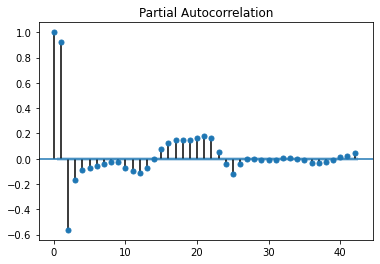

In [64]:
plot_pacf(energy_train);

The PACF plot above shows the correlation between a variable and the lag of itself that is not explained by the correlation with lower-order lags.

The shaded area (which is difficult to see) is the confidence interval. When a lag drops into the shaded area, it is no longer a statistically significant correlation.

A sharp drop after lag 'k' indicates an AR(k) model. In this case, there is a sharp drop after lag 1, indicating an AR(1) model.

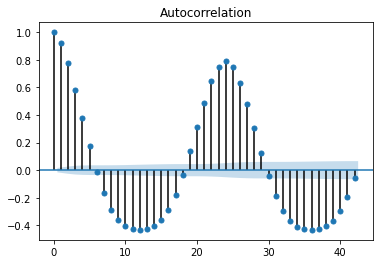

In [66]:
plot_acf(energy_train);

The ACF plot above shows a strong correlation with higher order lags, this indicates we should take a first order difference of the series.

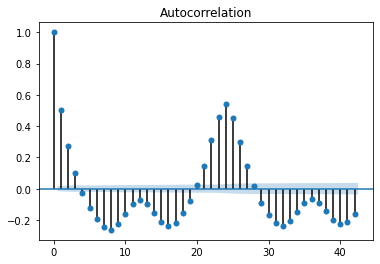

In [61]:
plot_acf(energy_train.diff().dropna());

The ACF plot functions similar to the PACF plot from earlier, only for the MA term instead of the AR term. A sharp drop off after k indicates an MA(k) model. In this case, there is a rather sharp drop after the first three lags, so i will experiment with MA(1), MA(2), and MA(3) models. First, an autoregressive model with order (1,1,0).

In [67]:
ar = ARIMA(energy_train, order=(1,1,0)).fit()

In [68]:
ar.aic

270029.372669743

In [69]:
np.sqrt(mse(energy_train[1:], ar.predict(typ=('levels'))))

1774.9933323080393

Simply by adding an AR term, the auto-regressive model is outperforming all of my previous standard models. Next, the 3 moving average models.

In [70]:
ma_1 = ARIMA(energy_train, order=(0,1,1)).fit()

In [71]:
ma_1.aic

271086.4560607041

In [73]:
np.sqrt(mse(energy_train[1:], ma_1.predict(typ=('levels'))))

1837.937096140782

The single lag moving average model performed better than the random walk model, but slightly worse than the auto-regressive model.

In [74]:
ma_2 = ARIMA(energy_train, order=(0, 1, 2)).fit()

In [75]:
ma_2.aic

270220.30809457065

In [76]:
np.sqrt(mse(energy_train[1:], ma_2.predict(typ=('levels'))))

1786.083827948051

The MA(2) model performed very similarly to the AR model. Lastly a moving average model including three lags, then I can perform a full ARIMA model with both Auto-regressive and moving-average functionality.

In [77]:
ma_3 = ARIMA(energy_train, order=(0,1,3)).fit()

In [78]:
ma_3.aic

269981.39062145376

In [79]:
np.sqrt(mse(energy_train[1:], ma_3.predict(typ=('levels'))))

1771.9543354410075

The moving average model with three lags is the best performing model thus far. Now I will combine the AR and MA terms. Considering the moving average with three lags performed best, the ARIMA model will have order (1,1,3) -> 1 AR lag, first order difference, 3 MA lags.

In [85]:
model1 = ARIMA(energy_train, order=(1,1,2)).fit()

There was an error with MA(3), so I performed MA(2) instead.

In [86]:
model1.aic

270176.4399292061

In [87]:
np.sqrt(mse(energy_train[1:], model1.predict(typ=('levels'))))

1783.3655050567552

The full ARIMA model performed slightly worse than the MA(3) model, which is the best performing model thus far. Next, I want to add the weather conditoins as exogenous variables. I will need to perform preprocessing steps. This was all focused on the training data, I would now like to see how the models perform with the validation data.

### Validation Performance with baseline models

The three best performing models were the auto-regressive, moving average with three lags, and ARIMA of order (1,1,2), so those are the models I will check with validation data

In [90]:
ar_val_preds = ar.predict(start=energy_val.index[0], end=energy_val.index[-1], typ=('levels'))
ma_3_val_preds = ma_3.predict(start=energy_val.index[0], end=energy_val.index[-1], typ=('levels'))
model1_val_preds = model1.predict(start=energy_val.index[0], end=energy_val.index[-1], typ=('levels'))

Next I will print RMSE for each of the three models performance on the validation data.

In [91]:
print('RMSE for validation with AR: {}'.format(np.sqrt(mse(energy_val, ar_val_preds))))
print('RMSE for validation with MA: {}'.format(np.sqrt(mse(energy_val, ma_3_val_preds))))
print('RMSE for validation with ARIMA: {}'.format(np.sqrt(mse(energy_val, model1_val_preds))))

RMSE for validation with AR: 4430.776471562345
RMSE for validation with MA: 4431.41394541956
RMSE for validation with ARIMA: 4574.750944978667


The validation scores are more than double that of the training scores. I was incorrect before when i said that the time series models were performing better than the standard models from before. The best standard model produced an RMSE of 2053 on the testing set. Once I add the weather data, the model's performance should improve.

### Process Weather data for exogenous variables

In [88]:
weather.head()

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,
2018-01-29 00:23:00,30.34,28,30,92,29.51,5.00,14,330,NaN,80.0
2018-01-29 00:42:00,30.35,28,30,92,29.52,6.00,13,320,NaN,80.0
2018-01-29 00:51:00,30.34,28,30,93,29.51,6.00,15,330,NaN,80.0
2018-01-29 00:53:00,30.34,28,30,92,29.51,6.00,15,330,0.00,80.0
2018-01-29 01:53:00,30.34,28,30,92,29.51,3.00,10,340,0.00,80.0


The time stamps on the weather data are inconsistent. So I will likely have to play around with the splits before I get them right. 

In [168]:
weather_train = weather['2018-01-30 00:00:00': '2019-10-24 02:00:00']
weather_val = weather['2019-10-24 02:00:00': '2020-03-01 12:00:00']
weather_test = weather['2020-03-07 12:00:00':]

Now that the weather data has been split on the same time stamps as the energy data, I can impute the missing data using the impute_df function in data_processing.py file. Following imputation, I will reformat to hourly format to match energy data.

In [169]:
# instantiate Iterative Imputer objecter
imp = IterativeImputer(random_state=42)

In [170]:
weather_train_imp = dp.impute_df(weather_train, imp, train=True)
weather_val_imp = dp.impute_df(weather_val, imp, train=False)
weather_test_imp = dp.impute_df(weather_test, imp, train=False)

In [171]:
weather_train_hourly = weather_train_imp.resample('H').mean()
weather_val_hourly = weather_val_imp.resample('H').mean()
weather_test_hourly = weather_test_imp.resample('H').mean()

And finally, check that the weather and energy data splits line up.

In [172]:
weather_train_hourly.tail()

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,
2019-10-23 21:00:00,30.00,48.884111,58.0,73.453199,29.180000,10.0,21.0,200.0,0.000000,0.000000
2019-10-23 22:00:00,30.01,47.361363,55.0,77.120289,29.190198,10.0,16.0,200.0,0.004138,42.373430
2019-10-23 23:00:00,30.03,47.782272,55.0,78.355836,29.209710,10.0,11.0,200.0,0.001075,35.178675
2019-10-24 00:00:00,30.05,47.604808,56.0,75.247025,29.230000,10.0,15.0,220.0,0.000000,0.000000
2019-10-24 01:00:00,30.07,46.737780,55.0,75.499016,29.250000,10.0,14.0,230.0,0.000000,0.000000


In [182]:
weather_train_hourly.isna().sum()

HourlyAltimeterSetting       8
HourlyDewPointTemperature    8
HourlyDryBulbTemperature     8
HourlyRelativeHumidity       8
HourlyStationPressure        8
HourlyVisibility             8
HourlyWindSpeed              8
HourlyWindDirection          8
HourlyPrecipitation          8
cloud_coverage               8
dtype: int64

In [181]:
weather_train_hourly[weather_train_hourly['HourlyAltimeterSetting'].isna() == True]

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,
2018-04-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-12 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-16 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-24 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-24 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So there are 8 rows in the training df that still contain missing values. Unfortunately I cannot just drop those, as the weather dataframe needs to match up with the energy dataframe exactly. Considering there are only 8, I am going to set them to 0 for now. I will decide how to properly handle them later. 

In [183]:
weather_train_hourly[weather_train_hourly['HourlyAltimeterSetting'].isna() == True] = 0

In [184]:
weather_train_hourly.isna().sum()

HourlyAltimeterSetting       0
HourlyDewPointTemperature    0
HourlyDryBulbTemperature     0
HourlyRelativeHumidity       0
HourlyStationPressure        0
HourlyVisibility             0
HourlyWindSpeed              0
HourlyWindDirection          0
HourlyPrecipitation          0
cloud_coverage               0
dtype: int64

In [186]:
scaler = StandardScaler()

In [187]:
weather_train_sc = scaler.fit_transform(weather_train_hourly)
weather_val_sc = scaler.transform(weather_val_hourly)
weather_test_sc = scaler.transform(weather_test_hourly)

In [188]:
model2 = ARIMA(energy_train, order=(1,1,0), exog=weather_train_sc).fit()

In [189]:
model2.aic

269976.96492893214

In [190]:
np.sqrt(mse(energy_train[1:], model2.predict(typ=('levels'))))

1770.7625084785147

<Figure size 432x288 with 0 Axes>

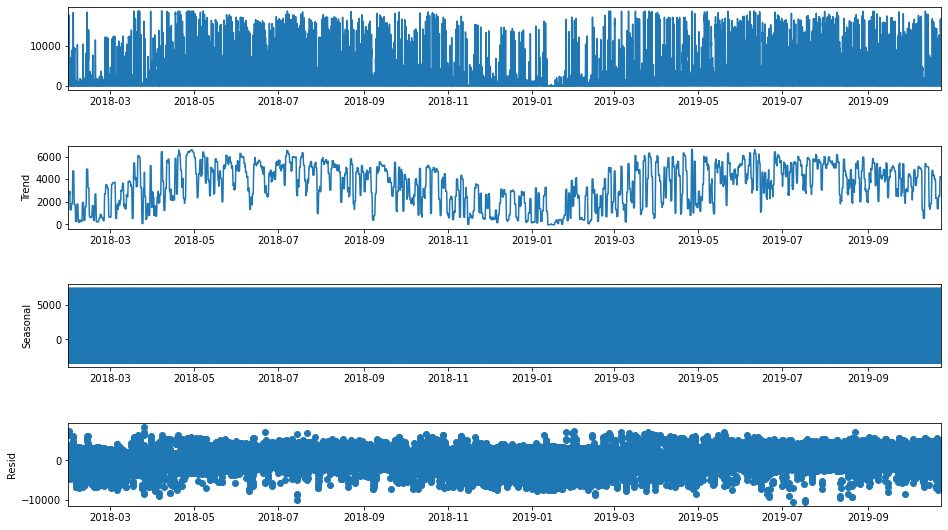

In [192]:
decomp = seasonal_decompose(energy_train)
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15, 8)

In [193]:
model3 = SARIMAX(energy_train, order=(1,1,0), seasonal_order=(1,1,0,24), 
    exog=weather_train_sc, enforce_stationarity=False, enforce_invertibility=False).fit()

In [194]:
model3.aic

267653.4169471489

In [196]:
np.sqrt(mse(energy_train, model3.predict(typ=('levels'))))

1690.732673187059